In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
import os

mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images=train_images.reshape(-1,28,28,1)/255.0
test_images=test_images.reshape(-1,28,28,1)/255.0

model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', input_shape=[28, 28, 1]))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=1)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)
loss_object = tf.keras.losses.CategoricalCrossentropy()

Using TensorFlow backend.
W0729 20:44:06.759449 19596 deprecation_wrapper.py:119] From C:\Users\Jaqen\x\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 20:44:06.840232 19596 deprecation_wrapper.py:119] From C:\Users\Jaqen\x\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 20:44:06.846226 19596 deprecation_wrapper.py:119] From C:\Users\Jaqen\x\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 20:44:06.906056 19596 deprecation_wrapper.py:119] From C:\Users\Jaqen\x\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0729 20:44:07.087572 19596 deprecation_wrapper.py:119] From C:\Users\Jaqen\x\lib\sit

Epoch 1/1
10000/10000 [==============================] - 2s 155us/step
Test accuracy: 0.9852


In [2]:
def zoo_create(input_image, input_label,h):
    e=input_image
    size=input_image.shape[0]
    temp=np.zeros((size,10))
    for i in range(temp.shape[0]):
        temp[i,input_label[i]]=1
    prediction=model(input_image)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        loss = loss_object(prediction, temp)
    gradient1 = tf.gradients(loss, input_image)    
    gradient2=(model(input_image+h*e)-model(input_image-h*e))/(2*h)
    gradient2=tf.reduce_sum(gradient2)
    gradient=gradient1*gradient2
    return tf.reshape(tf.sign(gradient),[size,28,28,1])

In [3]:
def blackbox(alpha,image,label,maxiter,Lambda,h):
    image_shadow=image
    temp=tf.zeros_like(image)
    for i in range(maxiter):
        perturbations=zoo_create(image,label,h)
        adv_x = image + alpha*perturbations - 2*alpha*Lambda*(image-image_shadow)
        adv_x = tf.clip_by_value(adv_x, 0, 1)
        image_shadow=image
        image=adv_x
        temp+=alpha*perturbations - 2*alpha*Lambda*(image-image_shadow)
        temp=tf.clip_by_value(temp,0,1)
    return image,temp

In [4]:
alpha=[0.01,0.01,0.02,0.02] 
Lambda=[0.8,1.8,1.8,2.5]
result=[]
for (lam,a) in zip(Lambda,alpha):
    tess_acc=0
    for i in range(10):
        test=test_images[1000*i:1000*(i+1),:,:,:]
        bat=test.shape[0]
        images = tf.cast(test, tf.float32)
        images = tf.reshape(images, [bat,28,28,1])
        adv_x,noise=blackbox(a,images,test_labels[1000*i:1000*(i+1)],10,lam,0.9)  
        adv_pre=model.predict(adv_x, steps=1)
        adv_class=adv_pre.argmax(axis=1)
        adv_con=[x[i] for x,i in zip(adv_pre,adv_class)]
        tess_acc+=model.evaluate(adv_x,test_labels[1000*i:1000*(i+1)],steps=1)[1]
    result.append(tess_acc/10)
for i in range(4):
    print('Lambda:{},alpha:{},tess_acc:{}'.format(Lambda[i],alpha[i],result[i]))

1/1 [==============================] - 15s 15s/step
Lambda:0.8,alpha:0.01,tess_acc:0.8510999917984009
Lambda:1.8,alpha:0.01,tess_acc:0.8641000092029572
Lambda:1.8,alpha:0.02,tess_acc:0.5008999958634377
Lambda:2.5,alpha:0.02,tess_acc:0.45850000381469724


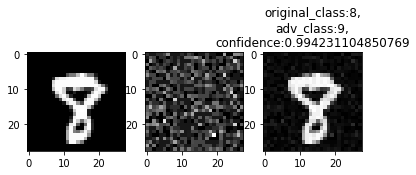

In [99]:
succ_image=adv_class==test_labels[:bat]
u=np.argwhere(succ_image==False).reshape((-1,))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1):
        f1=plt.figure()
        ax1=f1.add_subplot(131)
        ax2=f1.add_subplot(132)
        ax3=f1.add_subplot(133)
        p=np.random.choice(u)
        ax1.imshow(images[p,:,:,0].eval(),cmap='gray')
        ax2.imshow(noise[p,:,:,0].eval(),cmap='gray')
        ax3.imshow(adv_x[p,:,:,0].eval(),cmap='gray')
        plt.title('original_class:{},\nadv_class:{},\nconfidence:{}'.format(test_labels[p],adv_class[p],adv_con[p]))
        plt.show()